# Lithological Classification: Deep Learning Approach

## 1. Overview
This notebook implements a **Feed-Forward Neural Network (Multi-Layer Perceptron)** to classify lithofacies from well log measurements using the FORCE 2020 dataset.

### Workflow Differences from XGBoost
- **Imputation:** Unlike tree-based models, Neural Networks cannot handle NaNs. We apply mean imputation.
- **Scaling:** Input features are standardized (mean=0, std=1) to ensure stable gradient descent.
- **Architecture:** We use a deep architecture with Batch Normalization and Dropout to prevent overfitting.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
import gc
import warnings
import time

# Settings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 100)
sns.set_style("ticks")

## 2. Data Acquisition
Loading the training and validation data from the source repository.

In [ ]:
print("Loading datasets...")
start_time = time.time()

train = pd.read_csv('https://media.githubusercontent.com/media/Husayn01/Academic-Research/refs/heads/main/Data/train.csv', sep=';')
test = pd.read_csv('https://media.githubusercontent.com/media/Husayn01/Academic-Research/refs/heads/main/Data/test_features.csv', sep=';')
test_target = pd.read_csv('https://media.githubusercontent.com/media/Husayn01/Academic-Research/refs/heads/main/Data/test_target.csv', sep=';')

# Merge test target
test = test.merge(test_target, on=['WELL', 'DEPTH_MD'], how='left')

print(f"Data Loaded in {time.time() - start_time:.2f}s")
target_col = 'FORCE_2020_LITHOFACIES_LITHOLOGY'

Loading datasets...
Data Loaded in 22.36s


## 3. Feature Engineering
Applying domain-specific transformations (Petrophysics) and spatial windowing.

In [ ]:
def engineer_features(df):
    df = df.copy()
    # Drop sparse/noisy columns
    drop_cols = ['SGR', 'ROPA', 'RXO', 'MUDWEIGHT', 'DCAL', 'RMIC', 'FORCE_2020_LITHOFACIES_CONFIDENCE']
    df = df.drop(columns=[c for c in drop_cols if c in df.columns], errors='ignore')

    # Log transformations
    for col in ['RDEP', 'RMED', 'RSHA']:
        if col in df.columns:
            df[f'{col}_LOG'] = np.log1p(df[col])

    # Domain Ratios
    if 'GR' in df.columns and 'RHOB' in df.columns:
        df['GR_RHOB'] = df['GR'] / (df['RHOB'] + 0.001)

    if 'NPHI' in df.columns and 'RHOB' in df.columns:
        df['NPHI_RHOB_DIFF'] = df['NPHI'] - (2.65 - df['RHOB'])

    if 'PEF' in df.columns:
        df['PEF_SQ'] = df['PEF'] ** 2

    # Fill Categoricals
    if 'GROUP' in df.columns:
        df['GROUP'] = df['GROUP'].fillna('Unknown')
    if 'FORMATION' in df.columns:
        df['FORMATION'] = df['FORMATION'].fillna('Unknown')

    return df

def vectorized_windowing(df, cols, window_size=1):
    df_out = df.copy()
    df_out = df_out.sort_values(['WELL', 'DEPTH_MD'])
    for col in cols:
        if col not in df_out.columns:
            continue
        for i in range(1, window_size + 1):
            df_out[f'{col}_prev_{i}'] = df_out.groupby('WELL')[col].shift(i)
            df_out[f'{col}_next_{i}'] = df_out.groupby('WELL')[col].shift(-i)
        df_out[f'{col}_grad'] = df_out[col] - df_out.groupby('WELL')[col].shift(1)
    return df_out

print("Engineering features...")
train_eng = engineer_features(train)
test_eng = engineer_features(test)

aug_cols = ['GR', 'RHOB', 'NPHI', 'DTC', 'RDEP_LOG']
train_final = vectorized_windowing(train_eng, aug_cols, window_size=1)
test_final = vectorized_windowing(test_eng, aug_cols, window_size=1)

Engineering features...


## 4. Preprocessing for Neural Networks
1. **Encode Categoricals:** Convert text labels to integers.
2. **Impute Missing Values:** Fill NaNs with mean (Crucial for NN).
3. **Scale Data:** Standardize features to mean=0, std=1.

In [ ]:
# Encode Categoricals
cat_cols = ['GROUP', 'FORMATION', 'WELL']
for col in cat_cols:
    if col in train_final.columns:
        le = LabelEncoder()
        unique_vals = pd.concat([train_final[col], test_final[col]]).astype(str).unique()
        le.fit(unique_vals)
        train_final[col] = le.transform(train_final[col].astype(str))
        test_final[col] = le.transform(test_final[col].astype(str))

# Encode Target
le_target = LabelEncoder()
train_final[target_col] = le_target.fit_transform(train_final[target_col])
test_final[target_col] = le_target.transform(test_final[target_col])

# Separate Features/Target
drop_cols = ['DEPTH_MD', 'X_LOC', 'Y_LOC', 'Z_LOC', target_col]
X = train_final.drop(columns=drop_cols)
y = train_final[target_col]
X_test_data = test_final.drop(columns=drop_cols)
y_test_data = test_final[target_col]

# Clean column names
X.columns = [c.replace('[', '_').replace(']', '_') for c in X.columns]
X_test_data.columns = [c.replace('[', '_').replace(']', '_') for c in X_test_data.columns]

# IMPUTATION & SCALING
print("Imputing and Scaling data...")
# Align columns
X_test_data = X_test_data[X.columns]

# Impute
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)
X_test_imputed = imputer.transform(X_test_data)

# Scale
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)
X_test_scaled = scaler.transform(X_test_imputed)

print("Data ready for Neural Network.")

Imputing and Scaling data...
Data ready for Neural Network.


## 5. Model Definition and Training
We use a 3-layer MLP with Batch Normalization and Dropout for regularization.

In [ ]:
def build_model(input_dim, num_classes):
    model = Sequential([
        Dense(256, activation='relu', input_shape=(input_dim,)),
        BatchNormalization(),
        Dropout(0.3),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        Dense(64, activation='relu'),
        BatchNormalization(),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

folds = 10
skf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=42)

BATCH_SIZE = 1024
EPOCHS = 50
test_preds_nn = np.zeros((len(X_test_scaled), 12))
scores_nn = []

print(f"Starting {folds}-Fold Cross-Validation...")
cv_start = time.time()

for fold, (train_idx, val_idx) in enumerate(skf.split(X_scaled, y)):
    fold_start = time.time()
    X_train_fold, y_train_fold = X_scaled[train_idx], y[train_idx]
    X_val_fold, y_val_fold = X_scaled[val_idx], y[val_idx]

    model = build_model(X_scaled.shape[1], 12)

    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)

    history = model.fit(
        X_train_fold, y_train_fold,
        validation_data=(X_val_fold, y_val_fold),
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        callbacks=[early_stop, reduce_lr],
        verbose=0
    )

    # Predict
    val_probs = model.predict(X_val_fold, batch_size=BATCH_SIZE, verbose=0)
    test_probs = model.predict(X_test_scaled, batch_size=BATCH_SIZE, verbose=0)
    test_preds_nn += test_probs / folds

    acc = accuracy_score(y_val_fold, np.argmax(val_probs, axis=1))
    scores_nn.append(acc)

    print(f"   Fold {fold+1}/{folds} | Accuracy: {acc:.4f} | Epochs: {len(history.history['loss'])}")

    del model, X_train_fold, X_val_fold
    tf.keras.backend.clear_session()
    gc.collect()

print("="*40)
print(f"Average CV Accuracy: {np.mean(scores_nn):.4f}")
print(f"Total CV Time: {(time.time() - cv_start)/60:.2f} minutes")

Starting 10-Fold Cross-Validation...
   Fold 1/10 | Accuracy: 0.8841 | Epochs: 16
   Fold 2/10 | Accuracy: 0.8897 | Epochs: 19
   Fold 3/10 | Accuracy: 0.8985 | Epochs: 41
   Fold 4/10 | Accuracy: 0.8957 | Epochs: 38
   Fold 5/10 | Accuracy: 0.8889 | Epochs: 19
   Fold 6/10 | Accuracy: 0.8960 | Epochs: 39
   Fold 7/10 | Accuracy: 0.9001 | Epochs: 50
   Fold 8/10 | Accuracy: 0.8953 | Epochs: 29
   Fold 9/10 | Accuracy: 0.8949 | Epochs: 39
   Fold 10/10 | Accuracy: 0.8934 | Epochs: 29
Average CV Accuracy: 0.8936
Total CV Time: 21.34 minutes


## 6. Evaluation
Assessing model performance on the blind test set.

In [ ]:
final_test_labels = np.argmax(test_preds_nn, axis=1)
lithology_keys = {30000: 'Sandstone', 65030: 'Sandstone/Shale', 65000: 'Shale',
                  80000: 'Marl', 74000: 'Dolomite', 70000: 'Limestone',
                  70032: 'Chalk', 88000: 'Halite', 86000: 'Anhydrite',
                  99000: 'Tuff', 90000: 'Coal', 93000: 'Basement'}
target_names_mapped = [lithology_keys.get(code, str(code)) for code in le_target.classes_]
all_labels = np.arange(len(le_target.classes_))

print("\nClassification Report:")
print(classification_report(
    y_test_data,
    final_test_labels,
    labels=all_labels,
    target_names=target_names_mapped,
    zero_division=0
))


Classification Report:
                 precision    recall  f1-score   support

      Sandstone       0.77      0.82      0.79     24048
          Shale       0.84      0.85      0.85     83975
Sandstone/Shale       0.38      0.33      0.35     17558
      Limestone       0.40      0.50      0.44      4798
          Chalk       0.03      0.02      0.02       625
       Dolomite       0.00      0.00      0.00       416
           Marl       0.14      0.10      0.12      3306
      Anhydrite       1.00      0.28      0.44       125
         Halite       0.00      0.00      0.00         0
           Coal       0.83      0.58      0.68       690
       Basement       0.00      0.00      0.00         0
           Tuff       0.77      0.72      0.74      1245

       accuracy                           0.74    136786
      macro avg       0.43      0.35      0.37    136786
   weighted avg       0.73      0.74      0.73    136786



In [ ]:
import os

# Ensure the Results directory exists
result_dir = '../Results'
os.makedirs(result_dir, exist_ok=True)

# Generate the report string
report_str = classification_report(
    y_test_data,
    final_test_labels,
    labels=all_labels,
    target_names=target_names_mapped,
    zero_division=0
)

# Save to file
with open(f'{result_dir}/classification_report.txt', 'w') as f:
    f.write(report_str)

print(f"Classification report saved to {result_dir}/classification_report.txt")

Classification report saved to ../Results/classification_report.txt


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

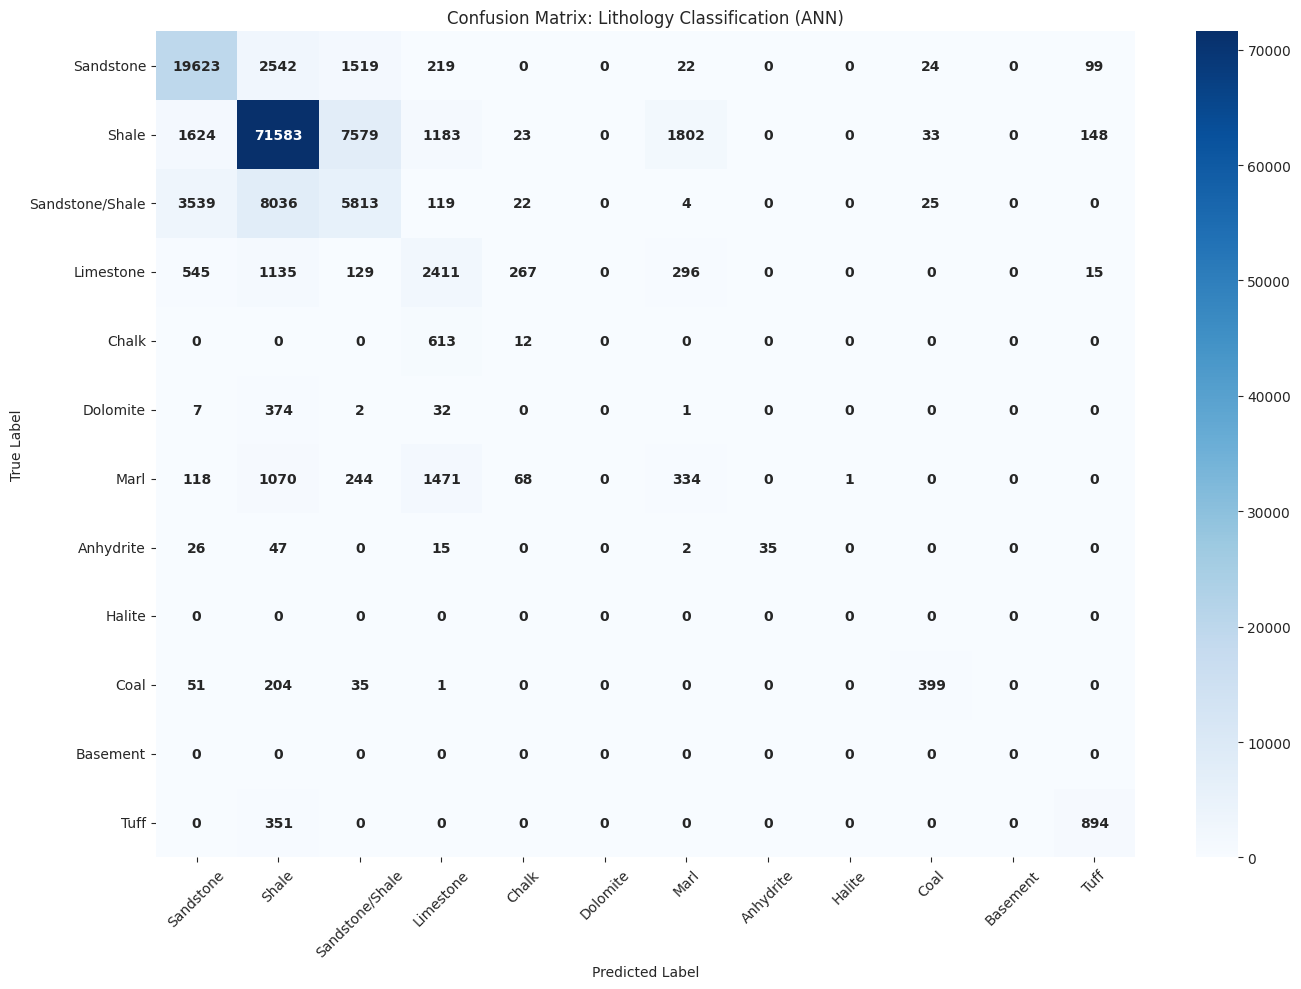

Confusion matrix plot saved to ../Results/confusion_matrix.png


In [ ]:
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
cm = confusion_matrix(y_test_data, final_test_labels, labels=all_labels)

plt.figure(figsize=(14, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names_mapped,
            yticklabels=target_names_mapped,
            annot_kws={"size": 10, "weight": "bold"})

plt.title('Confusion Matrix: Lithology Classification (ANN)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.xticks(rotation=45)
plt.yticks(rotation=0)

# Save figure
plt.tight_layout()
plt.savefig(f'{result_dir}/confusion_matrix.png', dpi=300)
plt.show()

print(f"Confusion matrix plot saved to {result_dir}/confusion_matrix.png")

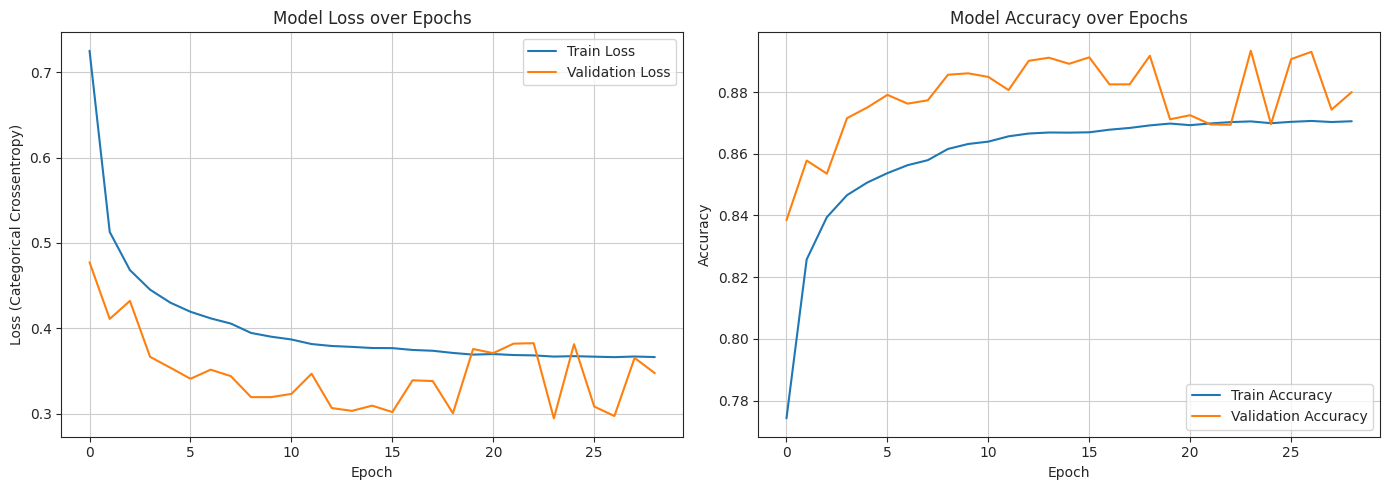

Training history plot saved to ../Results/training_history.png


In [ ]:
# Check if 'history' variable exists
if 'history' in locals():
    # Plot Loss
    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss over Epochs')
    plt.ylabel('Loss (Categorical Crossentropy)')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid(True)

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy over Epochs')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid(True)

    # Save figure
    plt.tight_layout()
    plt.savefig(f'{result_dir}/training_history.png', dpi=300)
    plt.show()

    print(f"Training history plot saved to {result_dir}/training_history.png")
else:
    print("Variable 'history' not found. If you re-run the model training, ensure you use: history = model.fit(...)")